## **Import packages**

In [ ]:
# Standard Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import scipy.stats as stats
!pip install researchpy
import researchpy as rp
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

# Pre-Processing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.impute import SimpleImputer

# Modeling Evaluation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Exploratory Data Analysis**

In [ ]:
# Read the dataset
dataset = pd.read_csv('8k_diabetes.csv')
print('Shape', dataset.shape)
dataset.head()

Shape (8000, 51)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,35,4,21,0,0,0,723,723,719,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,8,5,5,0,0,0,664,648,285,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified as to episode of care or not applicable","Diabetes mellitus of mother, complicating pregnancy, childbirth, or the puerperium, unspecified as to episode of care or not applicable",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home health service,NaN,7,MC,Family/GeneralPractice,12,0,21,0,0,1,481,428,276,9,>200,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoniae pneumonia],"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,33,1,5,0,0,0,682,41,250,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,"Streptococcus infection in conditions classified elsewhere and of unspecified site, streptococcus, unspecified","Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled"
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,31,0,13,0,0,0,296,250.01,298,7,None,None,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unspecified","Diabetes mellitus without mention of complication, type I [juvenile type], not stated as uncontrolled",Depressive type psychosis


In [ ]:
#Check for missing values and variables datatype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      8000 non-null   object
 1   gender                    8000 non-null   object
 2   age                       8000 non-null   object
 3   weight                    8000 non-null   object
 4   admission_type_id         7424 non-null   object
 5   discharge_disposition_id  7627 non-null   object
 6   admission_source_id       7250 non-null   object
 7   time_in_hospital          8000 non-null   int64 
 8   payer_code                8000 non-null   object
 9   medical_specialty         8000 non-null   object
 10  num_lab_procedures        8000 non-null   int64 
 11  num_procedures            8000 non-null   int64 
 12  num_medications           8000 non-null   int64 
 13  number_outpatient         8000 non-null   int64 
 14  number_emergency        

Creating a dataframe to easly overview the % of missing values, number of unique values and type for each feature.

In [ ]:
df_feature = pd.DataFrame( {'Feature Name': dataset.columns, 'Type': '', '% missing': '0%', 'Distinct values': 0 } )

In [ ]:
def update_df_feature(col_name, type_value):
    index = df_feature.index[df_feature['Feature Name'] == col_name].item()
    set_type(col_name, type_value, index)
    set_missing(col_name, index)
    set_unique_values(col_name, index)

def set_type(col_name, type_value, i):
    df_feature.at[i, 'Type'] = type_value

def set_missing(col_name, i):
    value = len(dataset[col_name][dataset[col_name] == 'Unknown']) + len(dataset[col_name][dataset[col_name] == 'None']) + len(dataset[col_name][dataset[col_name] == np.nan]) + dataset[col_name].isnull().sum()
    percentage = value * 100 / len(dataset)
    df_feature.at[i, '% missing'] = format(percentage, ".2f") + '%'

def set_unique_values(col_name, i):
    uniq_val = len(dataset[col_name].unique())
    df_feature.at[i, 'Distinct values'] = uniq_val

##### I'll start by defining each column its data type
- categorical
    - nominal-categorical - Data that can be labelled, but not ordered in a meangiful way.
    - ordinal-categorical - Data with ordered categories but the distances between the categories are not known.
    - binary-categorical - Data that can take exactly two possible values
    
- numeric

- text

##### RACE
There is value as '?' that means the data is unknown. I could have replaced it with Other, but may missclassify some rows that belong to the other category so I'll set as 'Unknown'.
Is nominal-categorical data.

In [ ]:
print("Race unique values", dataset.race.unique())
dataset['race'] = dataset['race'].replace('?', 'Unknown')
update_df_feature('race', 'nominal-categorical')

Race unique values ['Caucasian' 'AfricanAmerican' 'Hispanic' 'Other' 'Asian' '?']


##### GENDER
No missing values. Is a binary-categorical variable.

In [ ]:
print("Gender unique values", dataset.gender.unique())
update_df_feature('gender', 'binary-categorical')

Gender unique values ['Female' 'Male']


##### AGE
No missing values.
Is a ordinal-categorical variable as is given as age group interval

In [ ]:
print("Age unique values", dataset.age.unique())
update_df_feature('age', 'ordinal-categorical')

Age unique values ['[50-60)' '[20-30)' '[80-90)' '[70-80)' '[60-70)' '[30-40)' '[40-50)'
 '[10-20)' '[90-100)' '[0-10)']


##### WEIGHT
There is value as '?' that means the data is unknown, but seems for weight all the data is grouped into an 
interval by step '25'. I'll treat as another category, may remove it later when checking the correlation.Is ordinal categorical variable.

In [ ]:
print("Weight unique values", dataset.weight.unique())
# I was trying to replace it with the upcoming interval, but later on i decided isn't the best approach 
# when training data,so will treat like missing category
#dataset['weight'] = dataset['weight'].replace('?', '[175-200)')
#print("Weight unique values", dataset.weight.unique())
dataset['weight'] = dataset['weight'].replace('?', 'Unknown')
update_df_feature('weight', 'ordinal-categorical')

Weight unique values ['?' '[50-75)' '[75-100)' '[100-125)' '[150-175)' '[0-25)' '[125-150)'
 '[25-50)']


##### ADMISSION TYPE ID
There are values like Urgent and Emergency that maybe express the same thing so mapping into one value would be good, but as I don't have a description of the dataset will keep as seperated categories.
There are 576 missing values and I'm going to replace with 'Not Mapped'. It is nominal-categorical variable.

In [ ]:
print("Admission Type Id unique values", dataset.admission_type_id.unique())
dataset['admission_type_id'] = dataset['admission_type_id'].replace(np.nan, 'Unknown')
update_df_feature('admission_type_id', 'nominal-categorical')

Admission Type Id unique values ['Elective' 'Urgent' 'Not Available' 'Emergency' nan 'Not Mapped'
 'Newborn']


##### DISCHARGE DISPOSITION ID
It has low number of missing values so I'm replacing them with 'Unknown'. Is nominal-categorical variable.

In [ ]:
print("Discharge Disposition Id unique values", dataset.discharge_disposition_id.unique(), '\n')
dataset['discharge_disposition_id'] = dataset['discharge_disposition_id'].replace(np.nan, 'Unknown')
update_df_feature('discharge_disposition_id', 'nominal-categorical')

Discharge Disposition Id unique values ['Discharged to home'
 'Discharged/transferred to home with home health service' 'Expired'
 'Discharged/transferred to a long term care hospital.'
 'Discharged/transferred to SNF'
 'Discharged/transferred to another  type of inpatient care institution'
 'Not Mapped' 'Discharged/transferred to another short term hospital' nan
 'Left AMA'
 'Discharged/transferred to another rehab fac including rehab units of a hospital.'
 'Hospice / medical facility' 'Hospice / home'
 'Discharged/transferred/referred to a psychiatric hospital of a psychiatric distinct part unit of a hospital'
 'Discharged/transferred to ICF'
 'Discharged/transferred to home under care of Home IV provider'
 'Admitted as an inpatient to this hospital'
 'Discharged/transferred/referred another institution for outpatient services'
 'Discharged/transferred to a federal health care facility.'
 'Discharged/transferred within this institution to Medicare approved swing bed'
 'Discharged/tra

##### ADMISSION SOURCE ID
It has low number of missing values so I'm replacing them with 'Unknown'. Is nominal-categorical variable.

In [ ]:
print("Admission Source Id unique values", dataset.admission_source_id.unique(), '\n')
dataset['admission_source_id'] = dataset['admission_source_id'].replace(np.nan, 'Unknown')
update_df_feature('admission_source_id', 'nominal-categorical')

Admission Source Id unique values ['Physician Referral' nan 'Transfer from another health care facility'
 'Emergency Room' 'Transfer from a Skilled Nursing Facility (SNF)'
 'Transfer from a hospital' 'Not Mapped' 'Clinic Referral' 'HMO Referral'
 'Not Available' 'Court/Law Enforcement'] 



##### TIME IN HOSPITAL
Is numeric datatype.

In [ ]:
print("Time in hospital unique values", dataset.time_in_hospital.unique(), '\n')
update_df_feature('time_in_hospital', 'numeric')

Time in hospital unique values [ 1  2  7  4  5  6  3 14 10  8 11 12  9 13] 



##### PAYER CODE
Has high value with '?' and can't find a path to replace it, for this reason I'm going to map to 'Unknown' category, but may remove later if isn't needed. Is nominal-categorical variable.

In [ ]:
print("Payer Code unique values", dataset.payer_code.unique(), '\n')
dataset['payer_code'] = dataset['payer_code'].replace('?', 'Unknown')
update_df_feature('payer_code', 'nominal-categorical')
#dataset = dataset.drop('payer_code', axis=1)
#types = types.drop(index=types.index[types['Name'] == 'payer_code'], axis=0)

Payer Code unique values ['CP' 'UN' 'MC' '?' 'HM' 'SP' 'CM' 'BC' 'MD' 'WC' 'OG' 'PO' 'DM' 'SI' 'OT'
 'CH'] 



##### MEDICAL SPECIALTY
There is a high number with value ?, but i'm going to replace it with value 'Unknown' so can create a new category. It is nominal-categorical variable.

In [ ]:
print("Medical Specialty unique values", dataset.medical_specialty.unique(), '\n')
dataset['medical_specialty'] = dataset['medical_specialty'].replace('?', 'Unknown')
update_df_feature('medical_specialty', 'nominal-categorical')

Medical Specialty unique values ['Surgery-Neuro' '?' 'Family/GeneralPractice' 'Psychiatry' 'Cardiology'
 'InternalMedicine' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Emergency/Trauma' 'Gastroenterology' 'Orthopedics'
 'Cardiology-Pediatric' 'PhysicalMedicineandRehabilitation' 'Gynecology'
 'Pulmonology' 'Surgery-General' 'Pediatrics' 'Orthopedics-Reconstructive'
 'Surgery-Pediatric' 'Otolaryngology' 'Pediatrics-CriticalCare'
 'Hematology/Oncology' 'ObstetricsandGynecology'
 'Pediatrics-Endocrinology' 'Surgery-Vascular' 'Urology' 'Neurology'
 'Radiologist' 'Osteopath' 'Surgery-Cardiovascular' 'Psychology'
 'Oncology' 'Endocrinology' 'OutreachServices' 'Podiatry' 'Ophthalmology'
 'Hospitalist' 'Radiology' 'Obsterics&Gynecology-GynecologicOnco'
 'Surgery-Thoracic' 'Surgeon' 'Pathology' 'Surgery-Plastic'
 'InfectiousDiseases' 'Anesthesiology-Pediatric' 'Pediatrics-Pulmonology'
 'Pediatrics-Hematology-Oncology' 'Hematology' 'Surgery-Colon&Rectal'
 'Surgery-PlasticwithinHeadandNeck' '

##### NUM LAB PROCEDURES,   NUM PROCEDURES,  NUM MEDICATIONS,  NUMBER OUTPATIENT,  NUMBER EMERGENCY,  NUMBER INPATIENT
Are numeric.

In [ ]:
print("Num Lab Procedures unique values", dataset.num_lab_procedures.unique(), '\n')
print("Num Procedures unique values", dataset.num_procedures.unique(), '\n')
print("Num Medications unique values", dataset.num_medications.unique(), '\n')
print("Number Outpatient unique values", dataset.number_outpatient.unique(), '\n')
print("Number Emergency unique values", dataset.number_emergency.unique(), '\n')
print("Number Inpatient unique values", dataset.number_inpatient.unique(), '\n')
update_df_feature('num_lab_procedures', 'numeric')
update_df_feature('num_procedures', 'numeric')
update_df_feature('num_medications', 'numeric')
update_df_feature('number_outpatient', 'numeric')
update_df_feature('number_emergency', 'numeric')
update_df_feature('number_inpatient', 'numeric')

Num Lab Procedures unique values [ 35   8  12  33  31  29  46  49  54  47  45  60  43  38  50  66  59  17
   1  74  10  19  39  61  13  68  64  18  57  78  48  51  71  70  27  32
  58  44  37  42  53  52  11  14  41  26  75  40  34  79   2  23  56  36
  65  28  55  80  72  84  69  67  77  21  25  24  30   9  63 101  22   5
  16  62  15  89   4   3  87  20  91  73  83  81   6  76  86  85  90   7
 120  94 108  98  82 104  95  92 103  96 114 106  97 109  93 113 107  88] 

Num Procedures unique values [4 5 0 1 2 3 6] 

Num Medications unique values [21  5 13 10 20 17 12 44  8 34 19 11  6 15 23 29  9 46 18 14  7 24 26  4
 40 25 16 22  1 31 28 39 30 33 36 38 27  3  2 35 32 57 37 43 41 50 45 58
 47 42 51 56 62 60 75 63 59 67 48 61 54 52 49 53 74 81 55 65] 

Number Outpatient unique values [ 0  2  1  4  3  7  5  6 19 13  8 18  9 10 16 17 12 36 14 27 11 21] 

Number Emergency unique values [ 0  1  2  3  4  6 42  5  7  8 13] 

Number Inpatient unique values [0 1 2 4 3 7 5 6 9 8] 



##### DIAG 1, DIAG 2, DIAG 3
Diag 2, 3 Has '?' value.May seem like numeric but they have character in some of values.Also seems these diagonis values are redundant of the diag_desc so I may remove them later, for the moment I'm replacing with Unknown

In [ ]:
print("Diag 1", dataset.diag_1.unique())
print ('Number of rows with diag_1 value "?" is: ', len(dataset['diag_1'][dataset.diag_1 == '?']))

print("Diag 2", dataset.diag_2.unique())
print ('Number of rows with diag_2 value "?" is: ', len(dataset['diag_2'][dataset.diag_2 == '?']), '\n')
dataset['diag_2'] = dataset['diag_2'].replace('?', 'Unknown')

print("Diag 3", dataset.diag_3.unique())
print ('Number of rows with diag_3 value "?" is: ', len(dataset['diag_3'][dataset.diag_3 == '?']))
dataset['diag_3'] = dataset['diag_3'].replace('?', 'Unknown')

update_df_feature('diag_1', 'nominal-categorical')
update_df_feature('diag_2', 'nominal-categorical')
update_df_feature('diag_3', 'nominal-categorical')
#dataset = dataset.drop('diag_1', axis=1)
#types = types.drop(index=types.index[types['Name'] == 'diag_1'], axis=0)

#dataset = dataset.drop('diag_2', axis=1)
#types = types.drop(index=types.index[types['Name'] == 'diag_2'], axis=0)

#dataset = dataset.drop('diag_3', axis=1)
#types = types.drop(index=types.index[types['Name'] == 'diag_3'], axis=0)

Diag 1 ['723' '664' '481' '682' '296' '428' '434' '558' '440' '997' '250.8'
 '250.7' '584' '414' '250.82' '415' '432' '786' '410' '276' '204' '715'
 '250.11' 'V57' '403' '491' '618' '790' '593' '784' '824' '250.4' '295'
 '218' '820' '250.6' '996' '780' '250.02' '458' '433' '453' '435' '518'
 '486' '540' '487' '845' '821' '722' '823' '843' '38' '812' '153' '564'
 '507' '599' '427' '802' '562' '707' '493' '578' '727' '781' '225' '519'
 '577' '536' '537' '53' '571' '250.81' '345' '162' '437' '998' '474'
 '250.42' '560' '590' '556' '384' '436' '530' '553' '787' '250.13' '569'
 '349' '482' '189' '278' '535' '592' '608' '401' '112' '995' '882' '511'
 '202' '277' '733' '197' '642' '294' '250.83' '648' '555' '813' '724'
 '250.21' '426' '250.32' '552' '465' '532' '411' '402' '574' '235'
 '250.03' '239' '600' '865' '579' '531' '171' '404' '789' '429' '287'
 '285' '431' '250.01' '348' '575' '250.43' '729' '298' '398' '728' '8'
 '607' '810' '444' '709' '250.22' '726' '424' '510' '566' '332' '490'


##### NUMBER DIAGNOSES
Is numeric.

In [ ]:
print("Number Diagnoses unique value", dataset.number_diagnoses.unique())
update_df_feature('number_diagnoses', 'numeric')

Number Diagnoses unique value [9 6 3 7 8 5 4 2 1]


###### MAX GLU SERUM
Has a high number of 'None' values but for the moment I'm going to treat it as different category. Is ordinal-categorical variable.

In [ ]:
print("Max Glu Serum unique value", dataset.max_glu_serum.unique())
print('Number of rows with max glu value "None" is: ', len(dataset['max_glu_serum'][dataset.max_glu_serum == 'None']))
update_df_feature('max_glu_serum', 'ordinal-categorical')
#dataset = dataset.drop('max_glu_serum', axis=1)
#types = types.drop(index=types.index[types['Name'] == 'max_glu_serum'], axis=0)

Max Glu Serum unique value ['None' '>200' 'Norm' '>300']
Number of rows with max glu value "None" is:  7475


##### A1C RESULT
Same as Max Glu Serum

In [ ]:
print("A1Cresult unique value", dataset.A1Cresult.unique())
print('Number of rows with A1Cresult value "None" is: ', len(dataset['A1Cresult'][dataset.A1Cresult == 'None']))
update_df_feature('A1Cresult', 'ordinal-categorical')
#dataset = dataset.drop('A1Cresult', axis=1)
#types = types.drop(index=types.index[types['Name'] == 'A1Cresult'], axis=0)

A1Cresult unique value ['None' 'Norm' '>7' '>8']
Number of rows with A1Cresult value "None" is:  6709


##### METAFORMIN,     REPAGLINIDE,    NATEGLINIDE,    CHLORPROPAMIDE,    GLIMEPIRIDE,    ACETOHEXAMIDE,    GLIPIZIDE,    GLYBURIDE, TOLBUTAMIDE,   PIOGLITAZONE, ROSIGLITAZONE,   ACARBOSE,  MIGLITOL,  TROGLITAZONE,  TROLAZAMIDE,   EXAMIDE,   CITOGLIPTON,  INSULIN,   GLYBURIDE METFORMIN, GLIPIZIDE METFORMIN, GLIMEPIRIDE PIOGLITAZONE, METFORMIN PIOGLITAZONE

Are nominal-categorical data

In [ ]:
print("Metformin unique value", dataset.metformin.unique())
print("Repaglinide unique value", dataset.repaglinide.unique())
print("Nateglinide unique value", dataset.nateglinide.unique())
print("Chlorpropamide unique value", dataset.chlorpropamide.unique())
print("Glimepiride unique value", dataset.glimepiride.unique())
print("Acetohexamide unique value", dataset.acetohexamide.unique())
print("Glipizide unique value", dataset.glipizide.unique())
print("Glyburide unique value", dataset.glyburide.unique())
print("Tolbutamide unique value", dataset.tolbutamide.unique())
print("Pioglitazone unique value", dataset.pioglitazone.unique())
print("Rosiglitazone unique value", dataset.rosiglitazone.unique())
print("Acarbose unique value", dataset.acarbose.unique())
print("miglitol unique value", dataset.miglitol.unique())
print("troglitazone unique value", dataset.troglitazone.unique())
print("tolazamide unique value", dataset.tolazamide.unique())
print("examide unique value", dataset.examide.unique())
print("citoglipton unique value", dataset.citoglipton.unique())
print("insulin unique value", dataset.insulin.unique())
print("glyburide.metformin unique value", dataset['glyburide.metformin'].unique())
print("glipizide.metformin unique value", dataset['glipizide.metformin'].unique())
print("glimepiride.pioglitazone unique value", dataset['glimepiride.pioglitazone'].unique())
print("metformin.rosiglitazone unique value", dataset['metformin.rosiglitazone'].unique())
print("metformin.pioglitazone unique value", dataset['metformin.pioglitazone'].unique())


update_df_feature('metformin', 'nominal-categorical')
update_df_feature('repaglinide', 'nominal-categorical')
update_df_feature('nateglinide', 'nominal-categorical')
update_df_feature('chlorpropamide', 'nominal-categorical')
update_df_feature('glimepiride', 'nominal-categorical')
update_df_feature('acetohexamide', 'nominal-categorical')
update_df_feature('glipizide', 'nominal-categorical')
update_df_feature('glyburide', 'nominal-categorical')
update_df_feature('tolbutamide', 'nominal-categorical')
update_df_feature('pioglitazone', 'nominal-categorical')
update_df_feature('rosiglitazone', 'nominal-categorical')
update_df_feature('acarbose', 'nominal-categorical')
update_df_feature('miglitol', 'nominal-categorical')
update_df_feature('troglitazone', 'nominal-categorical')
update_df_feature('tolazamide', 'nominal-categorical')
update_df_feature('examide', 'nominal-categorical')
update_df_feature('citoglipton', 'nominal-categorical')
update_df_feature('insulin', 'nominal-categorical')
update_df_feature('glyburide.metformin', 'nominal-categorical')
update_df_feature('glipizide.metformin', 'nominal-categorical')
update_df_feature('glimepiride.pioglitazone', 'nominal-categorical')
update_df_feature('metformin.rosiglitazone', 'nominal-categorical')
update_df_feature('metformin.pioglitazone', 'nominal-categorical') 


Metformin unique value ['No' 'Steady' 'Down' 'Up']
Repaglinide unique value ['No' 'Steady' 'Up' 'Down']
Nateglinide unique value ['No' 'Steady' 'Down' 'Up']
Chlorpropamide unique value ['No' 'Steady' 'Up']
Glimepiride unique value ['No' 'Steady' 'Up' 'Down']
Acetohexamide unique value ['No']
Glipizide unique value ['No' 'Steady' 'Up' 'Down']
Glyburide unique value ['No' 'Steady' 'Down' 'Up']
Tolbutamide unique value ['No' 'Steady']
Pioglitazone unique value ['No' 'Steady' 'Up' 'Down']
Rosiglitazone unique value ['No' 'Steady' 'Up' 'Down']
Acarbose unique value ['No' 'Steady' 'Up']
miglitol unique value ['No' 'Steady' 'Down']
troglitazone unique value ['No']
tolazamide unique value ['No' 'Steady']
examide unique value ['No']
citoglipton unique value ['No']
insulin unique value ['No' 'Steady' 'Down' 'Up']
glyburide.metformin unique value ['No' 'Steady' 'Down' 'Up']
glipizide.metformin unique value ['No' 'Steady']
glimepiride.pioglitazone unique value ['No']
metformin.rosiglitazone unique

###### CHANGE
Is binary-categorical

In [ ]:
print("change unique value", dataset.change.unique())
update_df_feature('change', 'binary-categorical')

change unique value ['No' 'Ch']


##### DIABETES MED
Is binary-categorical

In [ ]:
print("diabetesMed unique value", dataset.diabetesMed.unique())
update_df_feature('diabetesMed', 'binary-categorical')

diabetesMed unique value ['No' 'Yes']


##### READMITTED - TARGET VARIABLE
Is binary-categorical

In [ ]:
print("readmitted unique value", dataset.readmitted.unique())
update_df_feature('readmitted', 'binary-categorical')

readmitted unique value [False  True]


##### DIAG 1 2 3 DESC 
There are missing values in column diag_2_desc and diag_3_desc and I'm going to replace those with string '<nan>'. Are text data so i'm going to update the datatype from object to string.

In [ ]:
print("diag_1_desc unique value", dataset.diag_1_desc.unique(), '\n')
print("diag_2_desc unique value", dataset.diag_2_desc.unique(), '\n')
print("diag_3_desc unique value", dataset.diag_3_desc.unique(), '\n')
update_df_feature('diag_1_desc', 'text') 
update_df_feature('diag_2_desc', 'text') 
update_df_feature('diag_3_desc', 'text')
dataset['diag_2_desc'] = dataset['diag_2_desc'].fillna('<nan>')
dataset['diag_3_desc'] = dataset['diag_3_desc'].fillna('<nan>')

dataset['diag_1_desc'] = dataset['diag_1_desc'].astype('str')
dataset['diag_2_desc'] = dataset['diag_2_desc'].astype('str')
dataset['diag_3_desc'] = dataset['diag_3_desc'].astype('str')

diag_1_desc unique value ['Spinal stenosis in cervical region'
 'First-degree perineal laceration, unspecified as to episode of care or not applicable'
 'Pneumococcal pneumonia [Streptococcus pneumoniae pneumonia]'
 'Cellulitis and abscess of face'
 'Bipolar I disorder, single manic episode, unspecified'
 'Congestive heart failure, unspecified'
 'Cerebral thrombosis without mention of cerebral infarction'
 'Other and unspecified noninfectious gastroenteritis and colitis'
 'Atherosclerosis of aorta' 'Nervous system complication, unspecified'
 'Diabetes with other specified manifestations, type II or unspecified type, not stated as uncontrolled'
 'Diabetes with peripheral circulatory disorders, type II or unspecified type, not stated as uncontrolled'
 'Acute kidney failure'
 'Coronary atherosclerosis of unspecified type of vessel, native or graft'
 'Diabetes with other specified manifestations, type II or unspecified type, uncontrolled'
 'Acute cor pulmonale' 'Nontraumatic extradural hem

In [ ]:
# Missing values - Columns that have None, Unknown, ?, nan
print('Features by they category:')
df_feature

Features by they category:


,Feature Name,Type,% missing,Distinct values
0,race,nominal-categorical,2.25%,6
1,gender,binary-categorical,0.00%,2
2,age,ordinal-categorical,0.00%,10
3,weight,ordinal-categorical,95.94%,8
4,admission_type_id,nominal-categorical,7.20%,7
5,discharge_disposition_id,nominal-categorical,4.66%,22
6,admission_source_id,nominal-categorical,9.38%,11
7,time_in_hospital,numeric,0.00%,14
8,payer_code,nominal-categorical,53.25%,16
9,medical_specialty,nominal-categorical,40.36%,52


Now that I've seperate the features into categorical, numeric and text, I'll go through each of them to decide the features I'm going to use for the model.

Let's start with categorical variables. Metric that are commonly used to calculate the correlation between categorical variables:
##### 1. Tetrachoric Correlation
Used to calculate the correlation between binary categorical variables.

##### 2. Polychoric Correlation
Used to calculate the correlation between ordinal categorical variables.

##### 3. Cramer’s V
Used to calculate the correlation between nominal categorical variables.That's what I'm going to use.

#### Categorical Variables

REFERENCE: https://www.pythonfordatascience.org/chi-square-test-of-independence-python/

In [ ]:
df_corr = pd.DataFrame(columns=['Feature Name', "Cramer's V", 'Correlated with readmitted'])

def categorical_correlation():
    i = 0
    data_by_name = df_feature[df_feature.Type.str.contains('categorical').values]['Feature Name'].values
    for name in data_by_name: 
        crosstab, test_results, expected = rp.crosstab(dataset[name], dataset["readmitted"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
        value = test_results['results'].loc[2]
        df_corr.loc[i] = [name, value, value > 0.01] 
        i += 1 

In [ ]:
categorical_correlation()
df_corr

,Feature Name,Cramer's V,Correlated with readmitted
0,race,0.0863,True
1,gender,0.0022,False
2,age,0.0898,True
3,weight,0.1079,True
4,admission_type_id,0.0720,True
5,discharge_disposition_id,0.1615,True
6,admission_source_id,0.1173,True
7,payer_code,0.0905,True
8,medical_specialty,0.1611,True
9,diag_1,0.2743,True


Based on this observation these are 28 categorical features I'm going to use as have high correlation with target feature.

In [ ]:
# Categorical Features that I'm going to use
X_categorical = df_corr[df_corr['Correlated with readmitted'] == True]
categorical_columns =  X_categorical[:-1]['Feature Name'].values
print("len of categorical column", len(categorical_columns))
categorical_columns

len of categorical column 28


array(['race', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'miglitol',
       'insulin', 'glyburide.metformin', 'change', 'diabetesMed'],
      dtype=object)

#### Numeric variable

As the target variable has only two values I'm going to transform into numeric values False - 0 and True - 1. so I can easly find the correlation using pandas method

In [ ]:
dataset_copy = dataset.copy()
dataset_copy['readmitted'] = np.where(dataset_copy['readmitted'] == True, 1, 0)
dataset['readmitted'] = np.where(dataset['readmitted'] == True, 1, 0) #Change from boolean to 1, 0 values
corr_df = dataset_copy.corr()
corr_df

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
time_in_hospital,1.000000,0.293208,0.210275,0.486259,-0.032314,-0.003216,0.078494,0.261483,0.052480
num_lab_procedures,0.293208,1.000000,0.069638,0.244445,-0.024333,-0.004452,0.087106,0.159634,0.081914
num_procedures,0.210275,0.069638,1.000000,0.432212,-0.019481,-0.028414,-0.053056,0.099747,-0.014993
num_medications,0.486259,0.244445,0.432212,1.000000,0.028483,0.003648,0.045859,0.258667,0.039643
number_outpatient,-0.032314,-0.024333,-0.019481,0.028483,1.000000,0.080316,0.078425,0.098554,0.067409
number_emergency,-0.003216,-0.004452,-0.028414,0.003648,0.080316,1.000000,0.190083,0.028783,0.073627
number_inpatient,0.078494,0.087106,-0.053056,0.045859,0.078425,0.190083,1.000000,0.124015,0.192345
number_diagnoses,0.261483,0.159634,0.099747,0.258667,0.098554,0.028783,0.124015,1.000000,0.167716
readmitted,0.052480,0.081914,-0.014993,0.039643,0.067409,0.073627,0.192345,0.167716,1.000000


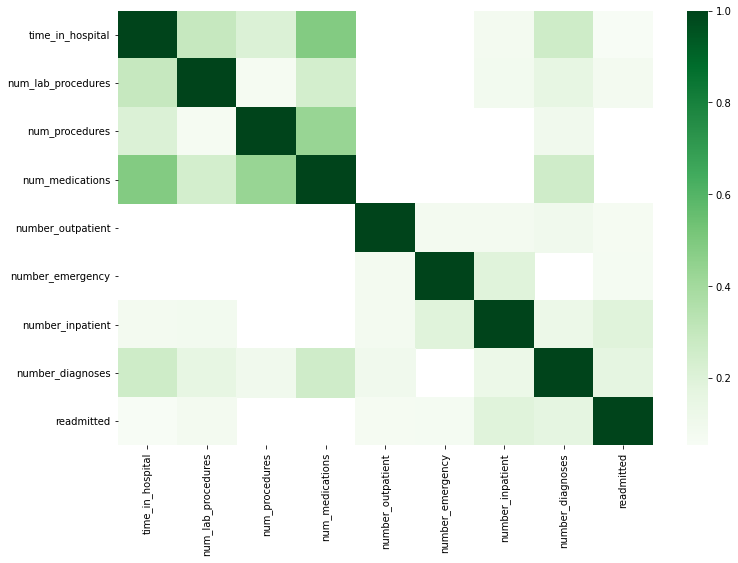

In [ ]:
corr = dataset_copy.corr()
filtered_val = corr_df[corr_df > 0.05]
plt.figure(figsize=(12,8))
sns.heatmap(filtered_val, cmap="Greens")

From the observation of the correlation matrix I'm choosing to keep the features
'number_diagnoses', 'number_inpatient', 'number_emergency', 'number_outpatient', 'num_lab_procedures', 'time_in_hospital' as the coeficciet correlation is higher than 0.01. I'm using that as my threshold.

In [ ]:
numerical_columns = np.delete(corr_df.columns.values, [2, 8])
numerical_columns

array(['time_in_hospital', 'num_lab_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'], dtype=object)

###### Text data

We have three columns for text data so I'm keeping them as feature variables.

In [ ]:
text_columns = np.array(['diag_1_desc', 'diag_2_desc', 'diag_3_desc'])
text_columns

array(['diag_1_desc', 'diag_2_desc', 'diag_3_desc'], dtype='<U11')

Next steps is to pre-process all the datatypes. I'm going to use Piplelines as steamline the preparation process.

REFERENCE: https://towardsdatascience.com/machine-learning-pipelines-with-scikit-learn-d43c32a6aa52

##  **Before running the pre-processing methods let's seperate the dataset into Training and Testing data**.

X - features data, represents the column from the join of categorical, numerical and text data.

Y- target data which is readmitted variable

In [ ]:
x_columns = np.concatenate((categorical_columns, numerical_columns, text_columns))
print('Length of X columns: ',len(x_columns))
x_columns

Length of X columns:  38


array(['race', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'miglitol',
       'insulin', 'glyburide.metformin', 'change', 'diabetesMed',
       'time_in_hospital', 'num_lab_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc'],
      dtype=object)

In [ ]:
X = dataset[x_columns]
Y = dataset['readmitted']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('Len of X_train', len(X_train))
print('Len of X_test', len(X_test))
print('Len of Y_train', len(Y_train))
print('Len of Y_test', len(Y_test))

Len of X_train 6400
Len of X_test 1600
Len of Y_train 6400
Len of Y_test 1600


## ***Pre-processing of categorical data***

**Approach 1 -** Ordinal Encoder (Convert each column value to a number between 0 - n_categories -1)
Label Encoder is used for features variables with dimension 1D, that's the difference with Ordinal Encoder that is well known for encoding of 2D categorical variables.Works good for tree models.

In [ ]:
#Creating oe transformer to encode the categorical data with OrdinalEncoder and LabelEncoder
lencoder = LabelEncoder()
le = Pipeline(steps=[('le', lencoder)])
oe = Pipeline(steps=[('oe', OrdinalEncoder(categories="auto", handle_unknown= "use_encoded_value", unknown_value=-999))])
                     
#Just an overview how the data will look like if using this algorithm
le_df = pd.DataFrame()
for name in categorical_columns: 
    new_column_name = name + ' LabelEnc'
    le_df[new_column_name] = lencoder.fit_transform(dataset[[name]])
le_df

,race LabelEnc,age LabelEnc,weight LabelEnc,admission_type_id LabelEnc,discharge_disposition_id LabelEnc,admission_source_id LabelEnc,payer_code LabelEnc,medical_specialty LabelEnc,diag_1 LabelEnc,diag_2 LabelEnc,diag_3 LabelEnc,max_glu_serum LabelEnc,A1Cresult LabelEnc,metformin LabelEnc,repaglinide LabelEnc,nateglinide LabelEnc,chlorpropamide LabelEnc,glimepiride LabelEnc,glipizide LabelEnc,glyburide LabelEnc,tolbutamide LabelEnc,pioglitazone LabelEnc,rosiglitazone LabelEnc,miglitol LabelEnc,insulin LabelEnc,glyburide.metformin LabelEnc,change LabelEnc,diabetesMed LabelEnc
0,2,5,0,0,1,6,3,44,325,292,298,2,2,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0
1,2,2,6,6,1,6,13,50,302,271,85,2,2,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0
2,2,8,0,3,11,10,6,5,202,162,77,0,2,1,1,1,0,1,1,1,0,1,1,1,2,1,1,1
3,0,5,0,1,1,9,13,50,306,146,39,2,2,1,1,1,0,1,1,1,0,1,1,1,2,1,1,1
4,0,5,0,1,1,2,14,34,104,40,97,2,2,2,1,1,0,1,2,1,0,1,1,1,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2,7,0,0,3,6,14,41,176,168,164,2,2,1,1,1,0,1,1,1,0,1,1,1,2,1,1,1
7996,2,5,0,6,1,2,13,3,85,311,76,2,2,1,1,1,0,2,1,1,0,1,2,1,2,1,0,1
7997,2,5,0,1,9,10,14,50,154,148,77,3,2,1,1,1,0,1,1,1,0,2,1,1,2,1,0,1
7998,2,8,0,6,3,2,6,43,165,161,162,2,2,1,1,1,0,1,1,1,0,1,1,1,3,1,0,1


**Approach 2 -** One-Hot encoding (Convert each category to new column with value to 0/1 (T/F)
For categorical variables where no ordinal relationship exists, the integer encoding may not be enough, at best, or misleading to the model at worst. Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance. In this case, a one-hot encoding can be applied to the ordinal representation

In [ ]:
ohencoder = OneHotEncoder(handle_unknown='ignore')
ohe = Pipeline(steps=[('ohe', ohencoder)])
                     
#Just an overview how the data will look like if using this algorithm
# As I'm using 38 categorical values, this process was crushing my pc, and as is just for understanding of mine
# as for the task itself im going to run it using the pipeline, them im gonna use only 2 categorical values
selected_categorical_columns =categorical_columns[:3]
ohe_df = dataset_copy[selected_categorical_columns]
for name in selected_categorical_columns: 
    new_column_name = name + ' OneHotEnc'
    # Converting type of columns to 'category'
    dataset[name] = dataset[name].astype('category')
    # Assigning numerical values and storing in another column
    col_name = name + 'cat'
    dataset_copy[col_name] = dataset[name].cat.codes
    df = pd.DataFrame(ohencoder.fit_transform(dataset_copy[[col_name]]).toarray())
    ohe_df = ohe_df.join(df, how = 'left', lsuffix='_' + name)
ohe_df

,race,age,weight,0_age,1_age,2_age,3_age,4_age,5_age,0,1,2,3,4,5,6_weight,7_weight,8,9,0,1,2,3,4,5,6,7
0,Caucasian,[50-60),Unknown,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Caucasian,[20-30),[50-75),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Caucasian,[80-90),Unknown,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AfricanAmerican,[50-60),Unknown,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AfricanAmerican,[50-60),Unknown,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Caucasian,[70-80),Unknown,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7996,Caucasian,[50-60),Unknown,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7997,Caucasian,[50-60),Unknown,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7998,Caucasian,[80-90),Unknown,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Pre-processing of numerical data.**

Usually we handle missing values for numerical types by:
- Impute with mean/median
- Use extreme values (for tree models).

In this case, we don't have missing values from the numerical data.

In [ ]:
df_feature[df_feature.Type == 'numeric']

,Feature Name,Type,% missing,Distinct values
7,time_in_hospital,numeric,0.00%,14
10,num_lab_procedures,numeric,0.00%,108
11,num_procedures,numeric,0.00%,7
12,num_medications,numeric,0.00%,68
13,number_outpatient,numeric,0.00%,22
14,number_emergency,numeric,0.00%,11
15,number_inpatient,numeric,0.00%,10
19,number_diagnoses,numeric,0.00%,9


**Approach 1** - Rescaling (Min-Max normalization - Features are rescaled to the range [0, 1]) 

In [ ]:
minmax_scaler = MinMaxScaler()
mm = Pipeline(steps=[('mm', minmax_scaler)])

#Let's review how the data will be
mm_df = dataset_copy[numerical_columns]
for name in numerical_columns: 
    new_column_name = name + ' MinMax'
    mm_df[new_column_name] = pd.DataFrame(minmax_scaler.fit_transform(dataset[[name]]), columns=[new_column_name])
mm_df

,time_in_hospital,num_lab_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,time_in_hospital MinMax,num_lab_procedures MinMax,num_medications MinMax,number_outpatient MinMax,number_emergency MinMax,number_inpatient MinMax,number_diagnoses MinMax
0,1,35,21,0,0,0,9,0.000000,0.285714,0.2500,0.000000,0.0,0.000000,1.000
1,2,8,5,0,0,0,6,0.076923,0.058824,0.0500,0.000000,0.0,0.000000,0.625
2,7,12,21,0,0,1,9,0.461538,0.092437,0.2500,0.000000,0.0,0.111111,1.000
3,4,33,5,0,0,0,3,0.230769,0.268908,0.0500,0.000000,0.0,0.000000,0.250
4,5,31,13,0,0,0,7,0.307692,0.252101,0.1500,0.000000,0.0,0.000000,0.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,8,56,27,0,0,1,9,0.538462,0.462185,0.3250,0.000000,0.0,0.111111,1.000
7996,2,44,18,0,0,0,8,0.076923,0.361345,0.2125,0.000000,0.0,0.000000,0.875
7997,1,25,16,0,0,1,9,0.000000,0.201681,0.1875,0.000000,0.0,0.111111,1.000
7998,7,61,22,0,0,1,9,0.461538,0.504202,0.2625,0.000000,0.0,0.111111,1.000


**Approach 2** - Standardization (Z-score  normalization - Features are scaled such that it’s mean is zero and variance is one)

In [ ]:
ss_scaler = StandardScaler()
ss = Pipeline(steps=[('ss', ss_scaler)])

#Let's review how the data will be
ss_df = dataset_copy[numerical_columns]
for name in numerical_columns: 
    new_column_name = name + ' SS'
    ss_df[new_column_name] = pd.DataFrame(ss_scaler.fit_transform(dataset[[name]]), columns=[new_column_name])
ss_df

,time_in_hospital,num_lab_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,time_in_hospital SS,num_lab_procedures SS,num_medications SS,number_outpatient SS,number_emergency SS,number_inpatient SS,number_diagnoses SS
0,1,35,21,0,0,0,9,-1.133249,-0.418115,0.644664,-0.247170,-0.169897,-0.454105,0.985032
1,2,8,5,0,0,0,6,-0.803133,-1.812091,-1.246410,-0.247170,-0.169897,-0.454105,-0.497520
2,7,12,21,0,0,1,9,0.847451,-1.605577,0.644664,-0.247170,-0.169897,0.734263,0.985032
3,4,33,5,0,0,0,3,-0.142899,-0.521373,-1.246410,-0.247170,-0.169897,-0.454105,-1.980072
4,5,31,13,0,0,0,7,0.187217,-0.624630,-0.300873,-0.247170,-0.169897,-0.454105,-0.003336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,8,56,27,0,0,1,9,1.177568,0.666088,1.353817,-0.247170,-0.169897,0.734263,0.985032
7996,2,44,18,0,0,0,8,-0.803133,0.046543,0.290088,-0.247170,-0.169897,-0.454105,0.490848
7997,1,25,16,0,0,1,9,-1.133249,-0.934403,0.053704,-0.247170,-0.169897,0.734263,0.985032
7998,7,61,22,0,0,1,9,0.847451,0.924232,0.762856,-0.247170,-0.169897,0.734263,0.985032


##**Implementation of a model to make predictions using text data using tf-idf**

In [ ]:
# Get text data from training and test dataset
def get_text_data(X_train, Y_train, X_test, Y_test):
    text_data_X_train = X_train[text_columns]
    text_data_Y_train = Y_train[X_train.index]
    text_data_X_test = X_test[text_columns]
    text_data_Y_test = Y_test[X_test.index]

    text_data_Y_train= text_data_Y_train.replace(True,1)
    text_data_Y_train = text_data_Y_train.replace(False,0)
    text_data_Y_test= text_data_Y_test.replace(True,1)
    text_data_Y_test = text_data_Y_test.replace(False,0)
    
    return text_data_X_train, text_data_Y_train, text_data_X_test, text_data_Y_test

In [ ]:
text_data_X_train, text_data_Y_train, text_data_X_test, text_data_Y_test = get_text_data(X_train, Y_train, X_test, Y_test)

In [ ]:
def process_text(content):
    # tokenize the words, by splitting into small units
    word = word_tokenize(content) 
    # remove stop words that doesn't add much meaning to a sentence
    word = [c for c in word if not c.lower() in stopwords.words('english')] 
    # lemmatize the words, return the base of of words known as lemma
    lemmatizer = WordNetLemmatizer()
    word = [lemmatizer.lemmatize(w, pos='a') for w in word] 
    return word;

In [ ]:
def create_processed_col(Xtrain, Xtest): 
    Xtrain['diag_1_desc_processed'] = Xtrain['diag_1_desc'].str.lower().apply(process_text)
    Xtrain['diag_2_desc_processed'] = Xtrain['diag_2_desc'].str.lower().apply(process_text)
    Xtrain['diag_3_desc_processed'] = Xtrain['diag_3_desc'].str.lower().apply(process_text)

    Xtest['diag_1_desc_processed'] = Xtest['diag_1_desc'].str.lower().apply(process_text)
    Xtest['diag_2_desc_processed'] = Xtest['diag_2_desc'].str.lower().apply(process_text)
    Xtest['diag_3_desc_processed'] = Xtest['diag_3_desc'].str.lower().apply(process_text)

In [ ]:
create_processed_col(text_data_X_train,text_data_X_test)

In [ ]:
def find_auc(ytest, ypred, ypred_proba):
    fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
    print("Classification Report\n", classification_report(ytest, ypred))
    return auc(fpr, tpr)

In [ ]:
def predict(model, Xtrain, Ytrain, Xtest, Ytest):
    model.fit(Xtrain, Ytrain)
    Ypred = model.predict(Xtest)
    Ypred_proba = model.predict_proba(Xtest)[:, 1]
    return Ypred_proba, find_auc(Ytest, Ypred, Ypred_proba)

In [ ]:
def vectorize_text(tf_idf, col_name, xtrain, xtest):
    Xtrain = tf_idf.fit_transform(xtrain[col_name].astype(str)) #fit transform apply to training data
    Xtest = tf_idf.transform(xtest[col_name].astype(str)) #apply transform to test data
    return Xtrain, Xtest

In [ ]:
def predict_text_data(model, col_name, Xtrain, Ytrain, Xtest, Ytest, tf_idf):
    if (tf_idf):
      Xtrain, Xtest = vectorize_text(tf_idf, col_name, Xtrain, Xtest)
    return predict(model, Xtrain, Ytrain, Xtest, Ytest)

In [ ]:
def evaluate_model(model, param_grid, Xtrain, Ytrain,  col_name='', isText=False, tf_idf=TfidfVectorizer(), cv=KFold()):
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv = cv, 
        n_jobs = -1,
        verbose = 2
      )
    model_name = type(model).__name__
    eval_df = pd.DataFrame(columns=['AUC', 'Best Params for ' + model_name])
    predicted_proba = []
    i = 1
    for train_index, test_index in cv.split(Xtrain, Ytrain):
        xtrain, ytrain, xtest, ytest = Xtrain.iloc[train_index], Ytrain.iloc[train_index], Xtrain.iloc[test_index], Ytrain.iloc[test_index]
        # Only for text data
        if (isText):
          xtrain, xtest = vectorize_text(tf_idf, col_name, xtrain, xtest)

        grid_search.fit(xtrain, ytrain)
        Y_Pred = grid_search.predict(xtest)
        Y_Pred_proba = grid_search.predict_proba(xtest)[:,1]
        predicted_proba.append(Y_Pred_proba)
        eval_df.loc[model_name + ' Fold:' + str(i), 'AUC'] = find_auc(ytest, Y_Pred, Y_Pred_proba)
        eval_df.loc[model_name + ' Fold:' + str(i), 'Best Params for ' + model_name] =  str(grid_search.best_params_)
        i += 1
    return eval_df, pd.DataFrame(np.ravel(predicted_proba), index=np.ravel(Xtrain.index), columns=[col_name + '_proba'])

In [ ]:
# Examine the vocabulary and document-term matrix together for training data
tf_idf = TfidfVectorizer()
Xtrain_ex, Xtest_ex = vectorize_text(tf_idf, 'diag_1_desc_processed', text_data_X_train, text_data_X_test)
pd.DataFrame(Xtrain_ex.toarray(), columns=tf_idf.get_feature_names())
# For test data
#pd.DataFrame(Xtest_ex.toarray(), columns=tf_idf.get_feature_names())

,abdominal,abnormal,abnormalities,abnormality,abscess,absence,acetabulum,achalasia,achieved,achlorhydria,acid,acquired,acromegaly,acute,adenovirus,adhesions,adhesive,adjustment,adrenal,adult,advice,aftercare,aggressive,agitans,air,airway,alcohol,alcoholic,alcoholism,alkaloids,allergic,alone,alteration,alzheimer,amnestic,amputation,anal,anaphylactic,and,anemia,aneurysm,angina,anhidrosis,ankle,ankylosing,anomalies,anomaly,anorexia,anterolateral,antidepressant,anxiety,aorta,aortic,aplastic,appendicitis,applicable,areola,ariboflavinosis,arterial,arteriosus,arteriovenous,artery,arthritis,arthropathy,articular,asthma,atherosclerosis,atrioventricular,atrophy,attention,aura,bacterial,bartonellosis,basal,base,basilar,beard,beck,behavior,bell,benign,bipolar,black,bladder,bleb,bleeding,block,blood,body,bone,bones,brachial,brain,breast,breathing,bronchitis,bronchopneumonia,budd,burn,calculus,callosities,candidiasis,capsulitis,carbuncle,carcinoma,cardia,cardiac,cardiospasm,care,carpal,cartilage,cataract,causes,cavity,celiac,cellulitis,central,cerebral,cerebrospinal,cerebrovascular,cerebrum,cervical,cervicitis,cervix,chiari,childbirth,cholecystitis,chronic,circulatory,ckd,classified,clavicle,closed,cognitive,coli,colic,colitis,collapse,coma,common,complete,complicating,complication,concussion,conditions,conduct,congenital,congestion,congestive,connective,consciousness,constipation,contact,contagiosum,contraceptive,contusion,cor,cord,corns,coronary,corpus,cortex,cortical,counseling,cranial,crisis,current,cushing,cyanides,cystic,cystitis,cysts,decubitus,defect,deficiency,deficits,defined,deformity,degenerative,degree,delirium,delivery,dementia,dengue,dependence,depressive,derivatives,dermatitis,dermatophytosis,detachment,detergents,device,diabetes,dialysis,dietetics,diffuse,digestive,disc,disease,diseases,disorder,disorders,displacement,dissection,disturbance,diverticulosis,diverticulum,drug,ductus,due,duodenal,dyschromia,dyspareunia,eardrum,eczema,effect,effects,effusion,elsewhere,embolism,emphysematous,empyema,encephalitis,encephalomyelitis,encounter,encysted,end,endocarditis,endocervicitis,endometriosis,endomyocardial,enteritis,enterocolitis,epididymitis,epididymo,epilepsy,episode,erythema,erythematosus,esophageal,esophagus,esotropia,essential,evaluation,exacerbation,examination,except,excluding,exercises,extracorporeal,extradural,extranodal,extremities,extremity,extrinsic,eye,eyes,face,factor,failed,failure,fatty,female,femoral,femur,fetal,fevers,fibrosis,fibrositis,findings,finger,fingers,first,fistula,fitting,flat,flexure,fluency,fluid,following,food,foot,forearm,foreign,found,fracture,function,furuncle,gallbladder,ganglia,gangrene,gastric,gastritis,gastroenteritis,gastrojejunal,general,generalized,genital,gigantism,gland,glands,glandular,glomerulonephritis,glottis,goiter,gouty,graft,gravidarum,gravis,hand,head,headache,heart,hematemesis,hemopericardium,hemorrhage,hemorrhoids,hepatic,hepatitis,hereditary,hernia,herpes,herpeticum,hiv,human,humerus,hydrocele,hydrocyanic,hydronephrosis,hyperemesis,hypernatremia,hyperosmolality,hyperosmolarity,hypertension,hypertensive,hypertrophic,hypertrophy,hypoglycemic,hypostasis,hypotension,ii,ileus,iliofemoral,ill,immunodeficiency,impairment,implant,induction,infarction,infection,infectious,infective,infiltrative,inflammation,inflammatory,influenza,ingrowing,inguinal,inhalation,injury,insufficiency,internal,intervertebral,intestinal,intestine,intoxication,intra,intracapsular,intracerebral,intracranial,intractable,intrauterine,intussusception,involuntary,involving,iron,isthmus,iv,joint,junction,juvenile,kaschin,ketoacidosis,kidney,klebsiella,labor,laceration,laryngopharyngitis,late,leg,leiomyoma,lesion,lesions,leukemia,leukoplakia,level,lie,ligament,limb,lip,lipoma,liver,lobes,loss,low,lumbar,lung,lupus,luts,lymph,lymphedema,lymphoid,lymphoma,m_ni,major,male,malignant,malleolus,malnutrition,management,manic,manifestations,marrow,maternal,maxillary,mechanical,meckel,meconium,media,medial,medical,medulla

Let's now evaluate for text data which is the best algorithm among NB and LR.

In [ ]:
def fit_predict_text(model, param_grid, cols_name, Xtrain, Ytrain, isText=False, tf_idf=TfidfVectorizer(), tf_idf2=TfidfVectorizer(), tf_idf3=TfidfVectorizer()):
  eval_df_1, Ypred_proba_1 = evaluate_model(model, param_grid, Xtrain, Ytrain, cols_name[0], isText, tf_idf1)
  eval_df_2, Ypred_proba_2 = evaluate_model(model, param_grid, Xtrain, Ytrain, cols_name[1], isText, tf_idf2)
  eval_df_3, Ypred_proba_3 = evaluate_model(model, param_grid, Xtrain, Ytrain, cols_name[2], isText, tf_idf3)
  merged_pdf = pd.merge(Ypred_proba_1, Ypred_proba_2, left_index=True, right_index=True)
  return pd.concat([eval_df_1, eval_df_2, eval_df_3]), pd.merge(merged_pdf, Ypred_proba_3, left_index=True, right_index=True)

**Approach 1 - Naive Bayes classifier(Multinomial NB)**

In [ ]:
tf_idf1 = TfidfVectorizer()
tf_idf2 = TfidfVectorizer()
tf_idf3 = TfidfVectorizer()
nb_model = MultinomialNB()
nb_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}
text_df, text_predict_proba_df_NB = fit_predict_text(MultinomialNB(), nb_grid, ['diag_1_desc_processed', 'diag_2_desc_processed', 'diag_3_desc_processed'], text_data_X_train, text_data_Y_train, True, tf_idf1, tf_idf2, tf_idf3)
text_df
#From Fold 1 - Fold 5 it represents column diag_1_desc_processed (thats why it has 15 data as 5 for each  3 of them)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Classification Report
               precision    recall  f1-score   support

           0       0.64      0.91      0.75       807
           1       0.46      0.13      0.20       473

    accuracy                           0.62      1280
   macro avg       0.55      0.52      0.48      1280
weighted avg       0.57      0.62      0.55      1280

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Classification Report
               precision    recall  f1-score   support

           0       0.59      0.99      0.74       752
           1       0.59      0.02      0.04       528

    accuracy                           0.59      1280
   macro avg       0.59      0.50      0.39      1280
weighted avg       0.59      0.59      0.45      1280

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Classification Report
               precision    recall  f1-score   support

           0       0.61      0.93      0.7

,AUC,Best Params for MultinomialNB
MultinomialNB Fold:1,0.542511,{'alpha': 10.0}
MultinomialNB Fold:2,0.553815,{'alpha': 10.0}
MultinomialNB Fold:3,0.560998,{'alpha': 10.0}
MultinomialNB Fold:4,0.544175,{'alpha': 10.0}
MultinomialNB Fold:5,0.544523,{'alpha': 10.0}
MultinomialNB Fold:1,0.53163,{'alpha': 10.0}
MultinomialNB Fold:2,0.545077,{'alpha': 10.0}
MultinomialNB Fold:3,0.520128,{'alpha': 10.0}
MultinomialNB Fold:4,0.533118,{'alpha': 10.0}
MultinomialNB Fold:5,0.524454,{'alpha': 10.0}


In [ ]:
text_predict_proba_df_NB

,diag_1_desc_processed_proba,diag_2_desc_processed_proba,diag_3_desc_processed_proba
1467,0.309545,0.197598,0.334645
5768,0.310851,0.214885,0.220122
5714,0.439920,0.396959,0.423279
1578,0.344409,0.203098,0.527109
6958,0.344409,0.336874,0.308025
...,...,...,...
5226,0.386270,0.329152,0.432109
5390,0.283759,0.273616,0.340402
860,0.339774,0.383202,0.318631
7603,0.269059,0.311107,0.344399


**Approach 2 - Logistic Regression**

In [ ]:
tf_idf1_lr = TfidfVectorizer()
tf_idf2_lr = TfidfVectorizer()
tf_idf3_lr = TfidfVectorizer()
model_lr = LogisticRegression()
lr_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 50),
}
text_df_lr, text_predict_proba_df_LR = fit_predict_text(model_lr, lr_grid, ['diag_1_desc_processed', 'diag_2_desc_processed', 'diag_3_desc_processed'], text_data_X_train, text_data_Y_train, True, tf_idf1_lr, tf_idf2_lr, tf_idf3_lr)
text_df_lr

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Classification Report
               precision    recall  f1-score   support

           0       0.64      0.91      0.75       807
           1       0.47      0.13      0.20       473

    accuracy                           0.62      1280
   macro avg       0.56      0.52      0.48      1280
weighted avg       0.58      0.62      0.55      1280

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Classification Report
               precision    recall  f1-score   support

           0       0.60      0.96      0.74       752
           1       0.57      0.08      0.15       528

    accuracy                           0.60      1280
   macro avg       0.58      0.52      0.44      1280
weighted avg       0.59      0.60      0.49      1280

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Classification Report
               precision    recall  f1-score   support

           0       0.61      0.95

,AUC,Best Params for LogisticRegression
LogisticRegression Fold:1,0.558898,"{'C': 0.18420699693267145, 'penalty': 'l2'}"
LogisticRegression Fold:2,0.559916,"{'C': 0.05963623316594643, 'penalty': 'l2'}"
LogisticRegression Fold:3,0.56521,"{'C': 0.05963623316594643, 'penalty': 'l2'}"
LogisticRegression Fold:4,0.570051,"{'C': 0.12648552168552957, 'penalty': 'l2'}"
LogisticRegression Fold:5,0.565851,"{'C': 0.05963623316594643, 'penalty': 'l2'}"
LogisticRegression Fold:1,0.553812,"{'C': 0.12648552168552957, 'penalty': 'l2'}"
LogisticRegression Fold:2,0.572458,"{'C': 0.0001, 'penalty': 'l2'}"
LogisticRegression Fold:3,0.518855,"{'C': 0.0001, 'penalty': 'l2'}"
LogisticRegression Fold:4,0.52074,"{'C': 0.0001, 'penalty': 'l2'}"
LogisticRegression Fold:5,0.540894,"{'C': 0.0001, 'penalty': 'l2'}"


In [ ]:
text_predict_proba_df_LR

,diag_1_desc_processed_proba,diag_2_desc_processed_proba,diag_3_desc_processed_proba
1467,0.330661,0.347387,0.404620
5768,0.307493,0.279138,0.403964
5714,0.462938,0.382776,0.404661
1578,0.430193,0.339510,0.405193
6958,0.430193,0.401093,0.404273
...,...,...,...
5226,0.364677,0.395161,0.387485
5390,0.374444,0.394954,0.390182
860,0.403304,0.395608,0.461296
7603,0.358084,0.395156,0.412408


Let's try how it will perform if we **merge the text columns** in one.

In [ ]:
def merge_text_data(Xtrain, Xtest):
    text_data_X_train['merged_data'] = Xtrain['diag_1_desc'].map(str) + '-' + Xtrain['diag_2_desc'].map(str) + '-' + Xtrain['diag_3_desc'].map(str)
    text_data_X_test['merged_data'] = Xtest['diag_1_desc'].map(str) + '-' + Xtest['diag_2_desc'].map(str) + '-' + Xtest['diag_3_desc'].map(str)

In [ ]:
merge_text_data(X_train, X_test)

Let's just see Logistic Regression for merged data as for seperated columns gave a better result

In [ ]:
model_merged = LogisticRegression()
merged_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 50),
}
tf_idf_merged = TfidfVectorizer()
eval_df_merged , Ypred_proba_merged = evaluate_model(model_merged, merged_grid, text_data_X_train, text_data_Y_train, 'merged_data', True, tf_idf_merged)
eval_df_merged

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Classification Report
               precision    recall  f1-score   support

           0       0.64      0.94      0.76       807
           1       0.51      0.11      0.18       473

    accuracy                           0.63      1280
   macro avg       0.58      0.52      0.47      1280
weighted avg       0.60      0.63      0.55      1280

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Classification Report
               precision    recall  f1-score   support

           0       0.60      0.97      0.74       752
           1       0.68      0.09      0.15       528

    accuracy                           0.61      1280
   macro avg       0.64      0.53      0.45      1280
weighted avg       0.64      0.61      0.50      1280

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Classification Report
               precision    recall  f1-score   support

           0       0.61      0.92

,AUC,Best Params for LogisticRegression
LogisticRegression Fold:1,0.591593,"{'C': 0.12648552168552957, 'penalty': 'l2'}"
LogisticRegression Fold:2,0.599261,"{'C': 0.08685113737513521, 'penalty': 'l2'}"
LogisticRegression Fold:3,0.587189,"{'C': 0.12648552168552957, 'penalty': 'l2'}"
LogisticRegression Fold:4,0.584933,"{'C': 0.08685113737513521, 'penalty': 'l2'}"
LogisticRegression Fold:5,0.571971,"{'C': 0.05963623316594643, 'penalty': 'l2'}"


In [ ]:
Ypred_proba_merged

,merged_data_proba
1467,0.329411
5768,0.267375
5714,0.464485
1578,0.406124
6958,0.424831
...,...
5226,0.390485
5390,0.353463
860,0.478150
7603,0.401854


Best performing model seems to be Logistic Regression. *Let's see how that will perform in out test data.*

In [ ]:
best_model = LogisticRegression(C= 0.0001, penalty= 'l2')
td_idf_1 = TfidfVectorizer()
td_idf_2 = TfidfVectorizer()
td_idf_3 = TfidfVectorizer()
td_idf_merged = TfidfVectorizer()
Y_pred_proba_1, auc_1 = predict_text_data(best_model, 'diag_1_desc_processed', text_data_X_train, text_data_Y_train, text_data_X_test, text_data_Y_test, td_idf_1)
Y_pred_proba_2, auc_2 = predict_text_data(best_model, 'diag_2_desc_processed', text_data_X_train, text_data_Y_train, text_data_X_test, text_data_Y_test, td_idf_2)
Y_pred_proba_3, auc_3 = predict_text_data(best_model, 'diag_3_desc_processed', text_data_X_train, text_data_Y_train, text_data_X_test, text_data_Y_test, td_idf_3)
Y_pred_proba_merged, auc_merged = predict_text_data(best_model, 'merged_data', text_data_X_train, text_data_Y_train, text_data_X_test, text_data_Y_test, tf_idf_merged)
final_result = pd.DataFrame({'Feature Name': ['diag_1_desc_processed', 'diag_2_desc_processed', 'diag_3_desc_processed', 'merged_data'], 'AUC': [auc_1, auc_2, auc_3, auc_merged]})
final_result

Classification Report
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       966
           1       0.00      0.00      0.00       634

    accuracy                           0.60      1600
   macro avg       0.30      0.50      0.38      1600
weighted avg       0.36      0.60      0.45      1600

Classification Report
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       966
           1       0.00      0.00      0.00       634

    accuracy                           0.60      1600
   macro avg       0.30      0.50      0.38      1600
weighted avg       0.36      0.60      0.45      1600

Classification Report
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       966
           1       0.00      0.00      0.00       634

    accuracy                           0.60      1600
   macro avg       0.30      0.50      0.38      1600
weigh

,Feature Name,AUC
0,diag_1_desc_processed,0.547290
1,diag_2_desc_processed,0.550129
2,diag_3_desc_processed,0.579754
3,merged_data,0.591630


Seems that the best AUC is coming from merged data, but there is no much difference with other features too so I'll keep using three features separetely.


In [ ]:
def array_to_df_merged(arr1, arr2, arr3, col, pos): 
  df1 = pd.DataFrame(arr1, columns=[col[0]], index=[pos])
  df2 = pd.DataFrame(arr2, columns=[col[1]], index=[pos])
  df3 = pd.DataFrame(arr3, columns=[col[2]], index=[pos])
  merged_df = pd.merge(df1, df2, left_index=True, right_index=True)
  return pd.merge(merged_df, df3, left_index=True, right_index=True)

In [ ]:
Xpred_proba = array_to_df_merged(Y_pred_proba_1, Y_pred_proba_2, Y_pred_proba_3, ['diag_1_desc_processed_proba', 'diag_2_desc_processed_proba', 'diag_3_desc_processed_proba'], text_data_X_test.index)
Xpred_proba

,diag_1_desc_processed_proba,diag_2_desc_processed_proba,diag_3_desc_processed_proba
2215,0.397382,0.396853,0.397727
2582,0.397168,0.396745,0.397633
1662,0.397493,0.396745,0.397617
3027,0.397225,0.397466,0.397797
4343,0.397430,0.397613,0.398122
...,...,...,...
1079,0.397488,0.397361,0.397828
7979,0.397442,0.397500,0.397797
1115,0.397338,0.396745,0.397595
6093,0.397510,0.397568,0.397828


##**Model stacking to incorporate tf-idf predictions for all 3 text fields**

I'm going to use the generated predictions from best model I trained before, and run another model after I evaluate it, stacking them together to get a better performance on my prediction.

In [ ]:
def model_stacking(model, Xtrain, Ytrain, param_grid, cv):
    grid_search = GridSearchCV(estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    df = pd.DataFrame(columns=['AUC', 'Grid Search Best Params'])
    i = 1
    pred = []
    model_name = type(model).__name__
    for train_index, test_index in cv.split(Xtrain, Ytrain):
        xtrain, ytrain, xtest, ytest = Xtrain.iloc[train_index], Ytrain.iloc[train_index], Xtrain.iloc[test_index], Ytrain.iloc[test_index]
        # fit the model
        grid_search.fit(xtrain, ytrain)
        # predict
        Y_Pred = grid_search.predict(xtest)
        Y_Pred_proba = grid_search.predict_proba(xtest)[:,1]
        pred.append(Y_Pred_proba)
        # calculate metrics
        df.loc[model_name + ' Fold:' + str(i), 'AUC'] = find_auc(ytest, Y_Pred, Y_Pred_proba)
        df.loc[model_name + ' Fold:' + str(i), 'Grid Search Best Params'] =  str(grid_search.best_params_)
        i += 1
    return df, pred

In [ ]:
def get_prediction_proba_col(): # From the best model in question 4
    return text_predict_proba_df_LR

In [ ]:
X_train_stack = get_prediction_proba_col()
Y_train_stack = text_data_Y_train # Values that already exists
sgd_model = SGDClassifier()
sgd_grid = {
    'loss': ['log'],
    'penalty': ['l2', 'l1'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}
eval_df_stacking, Ypred_proba_stacking = fit_predict_text(sgd_model, sgd_grid, ['diag_1_desc_processed_proba', 'diag_2_desc_processed_proba', 'diag_3_desc_processed_proba'], X_train_stack, Y_train_stack)
eval_df_stacking

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Classification Report
               precision    recall  f1-score   support

           0       0.65      0.84      0.74       807
           1       0.47      0.24      0.32       473

    accuracy                           0.62      1280
   macro avg       0.56      0.54      0.53      1280
weighted avg       0.59      0.62      0.58      1280

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Classification Report
               precision    recall  f1-score   support

           0       0.60      0.96      0.74       752
           1       0.57      0.08      0.15       528

    accuracy                           0.60      1280
   macro avg       0.58      0.52      0.44      1280
weighted avg       0.59      0.60      0.49      1280

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Classification Report
               precision    recall  f1-score   support

           0       0.60      1.00

,AUC,Best Params for SGDClassifier
SGDClassifier Fold:1,0.559738,"{'alpha': 0.0001, 'l1_ratio': 0.2, 'loss': 'log', 'penalty': 'l1'}"
SGDClassifier Fold:2,0.561841,"{'alpha': 0.0001, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'l1'}"
SGDClassifier Fold:3,0.573929,"{'alpha': 0.001, 'l1_ratio': 0.95, 'loss': 'log', 'penalty': 'l1'}"
SGDClassifier Fold:4,0.586999,"{'alpha': 0.0001, 'l1_ratio': 0.5, 'loss': 'log', 'penalty': 'l1'}"
SGDClassifier Fold:5,0.587605,"{'alpha': 0.001, 'l1_ratio': 0.8, 'loss': 'log', 'penalty': 'l2'}"
SGDClassifier Fold:1,0.556024,"{'alpha': 1e-05, 'l1_ratio': 0.05, 'loss': 'log', 'penalty': 'l1'}"
SGDClassifier Fold:2,0.561851,"{'alpha': 0.0001, 'l1_ratio': 1, 'loss': 'log', 'penalty': 'l1'}"
SGDClassifier Fold:3,0.581577,"{'alpha': 0.0001, 'l1_ratio': 0.95, 'loss': 'log', 'penalty': 'l1'}"
SGDClassifier Fold:4,0.587192,"{'alpha': 0.0001, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'l2'}"
SGDClassifier Fold:5,0.565851,"{'alpha': 0.001, 'l1_ratio': 0.1, 'loss': 'log', 'penalty': 'l1'}"


In [ ]:
Ypred_proba_stacking

,diag_1_desc_processed_proba_proba,diag_2_desc_processed_proba_proba,diag_3_desc_processed_proba_proba
1467,0.367019,0.207712,0.380085
5768,0.342828,0.195243,0.357659
5714,0.512187,0.326795,0.509886
1578,0.475814,0.298181,0.477196
6958,0.475215,0.291069,0.477198
...,...,...,...
5226,0.376949,0.368072,0.387903
5390,0.381239,0.374079,0.393761
860,0.404581,0.392052,0.411241
7603,0.378376,0.364039,0.383968


***Let's run our model-stack for test data.***

In [ ]:
X_proba_train_final = Ypred_proba_stacking
Y_train_final = text_data_Y_train
X_proba_test_final = Xpred_proba
Y_test_final = text_data_Y_test
best_stack_model = SGDClassifier(alpha= 0.0001, l1_ratio= 0.95, loss= 'log', penalty='l2')
Y_pred_proba_1, auc_1 = predict_text_data(best_stack_model, '	diag_1_desc_processed_proba_proba', X_proba_train_final, Y_train_final, X_proba_test_final, Y_test_final, False)
Y_pred_proba_2, auc_2 = predict_text_data(best_stack_model, '	diag_2_desc_processed_proba_proba', X_proba_train_final, Y_train_final, X_proba_test_final, Y_test_final, False)
Y_pred_proba_3, auc_3 = predict_text_data(best_stack_model, '	diag_3_desc_processed_proba_proba', X_proba_train_final, Y_train_final, X_proba_test_final, Y_test_final, False)

Classification Report
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       966
           1       0.00      0.00      0.00       634

    accuracy                           0.60      1600
   macro avg       0.30      0.50      0.38      1600
weighted avg       0.36      0.60      0.45      1600

Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       966
           1       0.40      1.00      0.57       634

    accuracy                           0.40      1600
   macro avg       0.20      0.50      0.28      1600
weighted avg       0.16      0.40      0.22      1600

Classification Report
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       966
           1       0.00      0.00      0.00       634

    accuracy                           0.60      1600
   macro avg       0.30      0.50      0.38      1600
weigh

In [ ]:
final_stacked_result = pd.DataFrame({'Feature Name': ['diag_1_desc_processed_proba_proba', 'diag_1_desc_processed_proba_proba', 'diag_1_desc_processed_proba_proba'], 'AUC': [auc_1, auc_2, auc_3]})
final_stacked_result

,Feature Name,AUC
0,diag_1_desc_processed_proba_proba,0.580014
1,diag_1_desc_processed_proba_proba,0.580011
2,diag_1_desc_processed_proba_proba,0.580216


In [ ]:
X_train_proba_text_FINAL = Ypred_proba_stacking
X_test_proba_text_FINAL = array_to_df_merged(Y_pred_proba_1, Y_pred_proba_2, Y_pred_proba_3, ['diag_1_desc_processed_proba_proba', 'diag_2_desc_processed_proba_proba', 'diag_3_desc_processed_proba_proba'], text_data_X_test.index)
X_test_proba_text_FINAL

,diag_1_desc_processed_proba_proba,diag_2_desc_processed_proba_proba,diag_3_desc_processed_proba_proba
2215,0.420245,0.514528,0.490248
2582,0.420134,0.514403,0.490126
1662,0.420132,0.514405,0.490129
3027,0.420554,0.514882,0.490586
4343,0.420823,0.515179,0.490877
...,...,...,...
1079,0.420532,0.514859,0.490565
7979,0.420574,0.514908,0.490611
1115,0.420115,0.514385,0.490108
6093,0.420624,0.514966,0.490667


In [ ]:
tt = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="missing"))])

## **Perform experimentation for multiple modeling algorithms**

For this task I'm going to use the piplelines I build above for categorical and numerical data, and predictions from model stacking of text data.

Before moving on with the modeling I have to merge the final propabilities of text data into traning and test dataset.

In [ ]:
def redefine_x_text(Xtrain, Xtest, Xtext_train, Xtext_test):
    Xtrain['diag_1_desc'] = Xtext_train['diag_1_desc_processed_proba_proba']
    Xtrain['diag_2_desc'] = Xtext_train['diag_2_desc_processed_proba_proba']
    Xtrain['diag_3_desc'] = Xtext_train['diag_3_desc_processed_proba_proba']

    Xtest['diag_1_desc'] = Xtext_test['diag_1_desc_processed_proba_proba'].values
    Xtest['diag_2_desc'] = Xtext_test['diag_2_desc_processed_proba_proba'].values
    Xtest['diag_3_desc'] = Xtext_test['diag_3_desc_processed_proba_proba'].values

In [ ]:
redefine_x_text(X_train, X_test, X_train_proba_text_FINAL, X_test_proba_text_FINAL)

In [ ]:
# Validate method to choose best model
def validate(preprocess, classifier_model, param_grid, Xtrain, Ytrain, xtest, ytest, cv=KFold()):
    grid_search = GridSearchCV(Pipeline(steps=[
            ('preprocess', preprocess),
            ('classifier', classifier_model)
            ]), 
            param_grid, 
            cv=3,
            n_jobs = -1,
            verbose = 2
    )
    df = pd.DataFrame(columns=['AUC', 'Grid Search Best Params'])
    
    fit_X_train = Xtrain
    model_name = type(classifier_model).__name__
    grid_search.fit(Xtrain, Ytrain)
    Y_Pred = grid_search.predict(xtest)
    Y_Pred_proba = grid_search.predict_proba(xtest)[:,1]
    df.loc[model_name, 'AUC'] = find_auc(ytest, Y_Pred, Y_Pred_proba)
    df.loc[model_name, 'Grid Search Best Params'] =  str(grid_search.best_params_)
    """
    # Commenting this code as I'm applying the fold inside GridSearchCV.
    i = 1
    for train_index, test_index in cv.split(Xtrain, Ytrain):
        xtrain, ytrain, xtest, ytest = Xtrain.iloc[train_index], Ytrain.iloc[train_index], Xtrain.iloc[test_index], Ytrain.iloc[test_index]
        grid_search.fit(xtrain, ytrain)
        Y_Pred = grid_search.predict(xtest)
        Y_Pred_proba = grid_search.predict_proba(xtest)[:,1]
        df.loc[model_name + ' Fold:' + str(i), 'AUC'] = find_auc(ytest, Y_Pred, Y_Pred_proba)
        df.loc[model_name + ' Fold:' + str(i), 'Grid Search Best Params'] =  str(grid_search.best_params_)
        i += 1
    """
    return df

**Experiment 1 - Decision Treess**

In [ ]:
#Creating preprocess column transformer to combine the pipelines of numerical and categorical data
preprocess = ColumnTransformer(
            transformers=[
                ('cont', ss, numerical_columns),
                ('cat', oe, categorical_columns),
                ('text', 'passthrough', text_columns),
            ],
            remainder='passthrough'
)

In [ ]:
tree_param = {'classifier__criterion': ['entropy', 'gini'], 
              'classifier__max_depth': [6, 25, 50, 70],
              'classifier__min_samples_leaf': [1, 2, 10]
             }
decision_tree_df = validate(preprocess, DecisionTreeClassifier(), tree_param, X_train, Y_train, X_test, Y_test)  
decision_tree_df

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Classification Report
               precision    recall  f1-score   support

           0       0.65      0.87      0.75       966
           1       0.60      0.30      0.40       634

    accuracy                           0.64      1600
   macro avg       0.63      0.58      0.57      1600
weighted avg       0.63      0.64      0.61      1600



,AUC,Grid Search Best Params
DecisionTreeClassifier,0.64398,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 6, 'classifier__min_samples_leaf': 10}"


*Let's see how it will perform in the test data*

In [ ]:
decision_tree_model = Pipeline(steps=[
            ('preprocess', preprocess),
            ('classifier', DecisionTreeClassifier(criterion= 'entropy', max_depth=6, min_samples_leaf=2)) #criterion= 'gini', max_depth=6, min_samples_leaf=10
])
proba_dt, auc_dt = predict(decision_tree_model, X_train, Y_train, X_test, Y_test)
print('AUC For Decision Tree: ', auc_dt)

Classification Report
               precision    recall  f1-score   support

           0       0.66      0.88      0.75       966
           1       0.63      0.30      0.40       634

    accuracy                           0.65      1600
   macro avg       0.64      0.59      0.58      1600
weighted avg       0.65      0.65      0.62      1600

AUC For Decision Tree:  0.6489589252241839


**Experiment 2 - Random Forest**

In [ ]:
#Parameter grid for Random Forest
rand_forest_parms = {'classifier__n_estimators': [5, 10, 20, 30, 50, 70, 80, 100, 150, 200, 300, 500],
                     #'classifier__max_features': ['auto', 'sqrt'],
                     'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                     #'classifier__min_samples_split': [2, 5, 10],
                     #'classifier__min_samples_leaf': [1, 2, 4],
                     #'classifier__bootstrap': [True, False],
                     }
random_forest_df = validate(preprocess, RandomForestClassifier(), rand_forest_parms, X_train, Y_train, X_test, Y_test)  
random_forest_df

Fitting 3 folds for each of 132 candidates, totalling 396 fits
Classification Report
               precision    recall  f1-score   support

           0       0.71      0.68      0.69       966
           1       0.54      0.58      0.56       634

    accuracy                           0.64      1600
   macro avg       0.62      0.63      0.63      1600
weighted avg       0.64      0.64      0.64      1600



,AUC,Grid Search Best Params
RandomForestClassifier,0.682476,"{'classifier__max_depth': 100, 'classifier__n_estimators': 200}"


*Let's see how will perform in testing data.*

In [ ]:
random_forest_model = Pipeline(steps=[
            ('preprocess', preprocess),
            ('classifier', RandomForestClassifier(max_depth= 30, n_estimators= 500)) #300 estimator = 0.69, 500 estimator = 0.7
])
proba_rf, auc_rf = predict(random_forest_model, X_train, Y_train, X_test, Y_test)
print('AUC For Random Forest: ', auc_rf)

Classification Report
               precision    recall  f1-score   support

           0       0.71      0.69      0.70       966
           1       0.55      0.58      0.57       634

    accuracy                           0.65      1600
   macro avg       0.63      0.64      0.63      1600
weighted avg       0.65      0.65      0.65      1600

AUC For Random Forest:  0.6939238526297915


**Experiment 3 - Gradient Boosting**

In [ ]:
#Parameter grid for Gradient Boosting
gradient_boost_param = {
    #"classifier__loss":["deviance"],
    "classifier__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1],
    #"classifier__min_samples_split": np.linspace(0.1, 0.5, 12),
    #"classifier__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "classifier__max_depth": [1, 3, 5, 7, 9],
    #"classifier__max_features":["log2","sqrt"],
    #"classifier__criterion": ["friedman_mse",  "mae"],
    #"classifier__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "classifier__n_estimators":[5, 50, 250, 300, 500]
}
gradient_boosting_df = validate(preprocess, GradientBoostingClassifier(), gradient_boost_param, X_train, Y_train, X_test, Y_test)  
gradient_boosting_df

Fitting 3 folds for each of 175 candidates, totalling 525 fits
Classification Report
               precision    recall  f1-score   support

           0       0.73      0.68      0.70       966
           1       0.56      0.62      0.58       634

    accuracy                           0.65      1600
   macro avg       0.64      0.65      0.64      1600
weighted avg       0.66      0.65      0.66      1600



,AUC,Grid Search Best Params
GradientBoostingClassifier,0.707626,"{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 500}"


*Let's check the performance in test data.*

In [ ]:
gradient_boosting_model = Pipeline(steps=[
            ('preprocess', preprocess),
            ('classifier', GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=300)) # 0,3, 1, 50 --> 0.7036  | 0.01, 3, 300 --> 0.7053
])
proba_gb, auc_gb = predict(gradient_boosting_model, X_train, Y_train, X_test, Y_test)
print('AUC For Gradient Boosting: ', auc_gb)

Classification Report
               precision    recall  f1-score   support

           0       0.75      0.58      0.65       966
           1       0.52      0.71      0.60       634

    accuracy                           0.63      1600
   macro avg       0.64      0.64      0.63      1600
weighted avg       0.66      0.63      0.63      1600

AUC For Gradient Boosting:  0.6989259426167944


**Logistic Regression**

In [ ]:
# Updating the preprocessor by using one hot encoder.
preprocess_lr = ColumnTransformer(
            transformers=[
                ('cont', ss, numerical_columns),
                ('cat', ohe, categorical_columns),
                ('text', 'passthrough', text_columns),
            ],
            remainder='passthrough'
)

In [ ]:
lr_param = {'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
            'classifier__C': np.logspace(-4, 4, 50),
}
logistic_reg_df = validate(preprocess_lr, LogisticRegression(), lr_param, X_train, Y_train, X_test, Y_test)  
logistic_reg_df

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Classification Report
               precision    recall  f1-score   support

           0       0.68      0.85      0.75       966
           1       0.63      0.39      0.48       634

    accuracy                           0.67      1600
   macro avg       0.65      0.62      0.62      1600
weighted avg       0.66      0.67      0.65      1600



,AUC,Grid Search Best Params
LogisticRegression,0.710525,"{'classifier__C': 0.019306977288832496, 'classifier__penalty': 'l2'}"


*Checking AUC in test data only.*

In [ ]:
logistic_reg_model = Pipeline(steps=[
            ('preprocess', preprocess),
            ('classifier', LogisticRegression(C=0.019, penalty='l2'))
])
proba_lr, auc_lr = predict(logistic_reg_model, X_train, Y_train, X_test, Y_test)
print('AUC For Logistic Regression: ', auc_lr)

Classification Report
               precision    recall  f1-score   support

           0       0.66      0.90      0.77       966
           1       0.68      0.30      0.42       634

    accuracy                           0.67      1600
   macro avg       0.67      0.60      0.59      1600
weighted avg       0.67      0.67      0.63      1600

AUC For Logistic Regression:  0.6945565635388704


## **Model Selection**

Below you will find the graph that compares the performance measure metric which is AUC between models itself.

<BarContainer object of 4 artists>

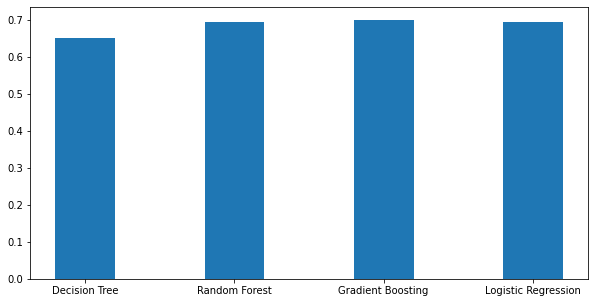

In [ ]:
import matplotlib.pyplot as plt
xbar = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']
fig = plt.figure(figsize = (10, 5))
ybar = [auc_dt, auc_rf, auc_gb, auc_lr]
plt.bar(xbar, ybar, width = 0.4)

The best algorithm which seems to have performed best in my evaluation method but also in test data is **Gradient Boosting** with AUC: **0.71**. I'm going to choose that as my best model. As you can see from the graph there isn't much different from the other models, but let's explain why I choose Gradient Boosting.
The choice I did was not only based on the AUC performance but also on keeping in mind what dataset I'm using, and what I'm trying to predict. The dataset contains numerical, categorical, and text features. I started the exploratory data analysis just by checking the missing values, finding the best approaches to replace those missing values, and running pre-processing method. So cases, when models weren't performing well, was when I was adding large params into GridSearch that could overfit it. The pre-processing was done using Pipeline for categorical and numerical data which I tried  Oridinal and One Hot Encoder for categorical and StandardScaler and MinMaxScaler for numerical. While for text data I applied tokenization, lemmatization, and Tf-Idf to fit and transform the data. Running model-stacking for text data helped my model too, as I was able to increase the performance by running multiple performances. Being able to run cross validation allowed me to compare different machine learning methods and get a sense of how they will work in practice. 